In [1]:
!pip install qiskit qiskit-aer pylatexenc matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=bd52cc1928b2a49d18c97d40dd52e201a555ae144c02a25d29a68877dff2bfcf
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556

# Protocolo de Teletransportación Cuántica

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex, plot_distribution, plot_state_city
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.result import marginal_counts
from qiskit import quantum_info

In [2]:
def crear_estado_alice(psi):
  q0_init_gate = Initialize(psi)
  q0_reverse_gate = q0_init_gate.gates_to_uncompute()
  return q0_init_gate, q0_reverse_gate

In [3]:
def crear_estado_de_bell (circuito , q0 , q1 , bell):
  circuito .h(q0)
  circuito .cx(q0 , q1)
  match bell:
    case "10":
      circuito .x(q1)
    case "01":
      circuito .z(q1)
    case "11":
      circuito .x(q1)
      circuito .z(q0)
    case "00":
      print ("Nada que hacer ")

In [4]:
def alice_operaciones(circuito, q0, q1):
    circuito.cx(q0, q1)
    circuito.h(q0)

def medir_luego_enviar(circuito, q0, q1, bit0, bit1):
    circuito.measure(q0, bit0)
    circuito.measure(q1, bit1)

In [5]:
def bob_operaciones(circuito, q2, bit0, bit1, bell):
    circuito.x(q2).c_if(bit1, not int(bell[0]))
    circuito.z(q2).c_if(bit0, not int(bell[1]))

In [6]:
def teleportation(psi, bell_state="00"):
    # Se define el estado inicial y su inverso
    q0_init, q0_reverse = crear_estado_alice(psi)

    # Se definen 3 qúbits
    qubits = QuantumRegister(3, name="q")

    # Se definen 2 canales clásicos
    bit0 = ClassicalRegister(1, name="bit0")
    bit1 = ClassicalRegister(1, name="bit1")

    # Se construye el objeto circuito
    circuito = QuantumCircuit(qubits, bit0, bit1)

    # Se inicializa el qúbit de Alice:
    circuito.append(q0_init, [0])
    circuito.barrier()

    #Se crea un par de qubits en un estado tipo Bell
    crear_estado_de_bell(circuito, qubits[1], qubits[2], bell_state)
    circuito.barrier()

    #Alice realiza operaciones con sus qubits
    alice_operaciones(circuito, qubits[0], qubits[1])

    #Alice mide sus qúbits y envía los resultados a Bob
    medir_luego_enviar(circuito, qubits[0], qubits[1], bit0, bit1)
    circuito.barrier()

    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, qubits[2], bit0, bit1, bell_state)

    return [circuito, qubits]

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


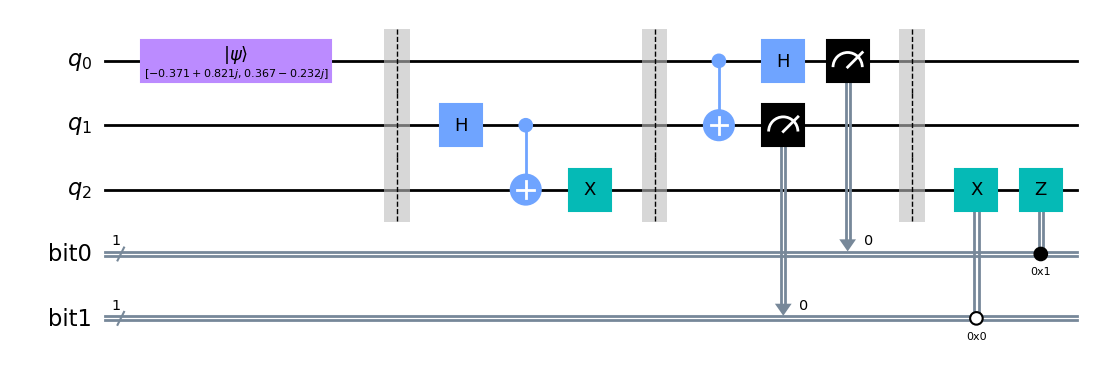

In [7]:
#Definimos la información del vector de estado que se desea teletransportar
psi = Statevector(random_statevector(2))

#Ejecutamos el algoritmo de teleportación en el estado Bell 10
qc, qubits = teleportation(psi, bell_state="10")

#Dibujamos el circuito resultante
qc.draw(output="mpl")

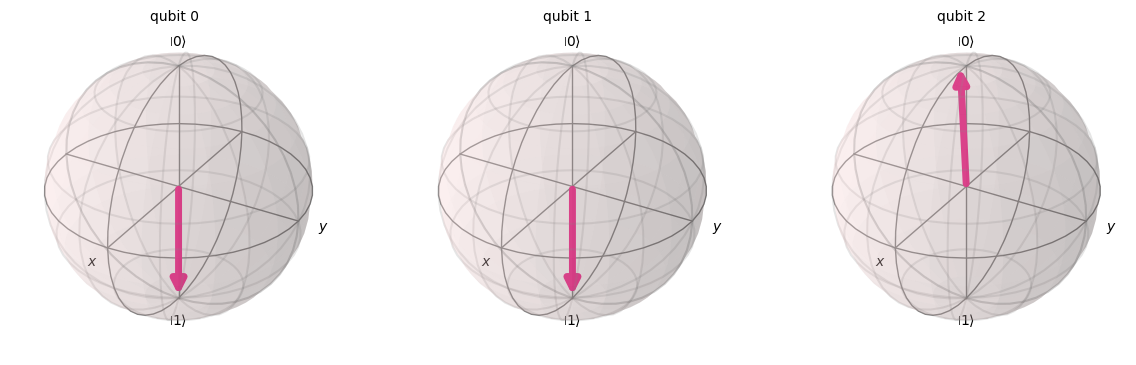

In [8]:
#Configuramos el simulador para correr el circuito
sim = Aer.get_backend("aer_simulator")
qc.save_statevector()

#Ejecutamos el circuito en el simulador y accedemos a los vectores de estado resultantes
out = execute(qc, sim).result().get_statevector()

#Dibujamos los vectores de estado de cada qúbit
plot_bloch_multivector(out)

# Protocolo Entanglement Swapping

In [9]:
def swapping(bell_state="00"):
    #Se definen 4 qubits
    qubits = QuantumRegister(4, name="q")

    #Se definen 4 canales clásicos
    bit0 = ClassicalRegister(1, name="bit0")
    bit1 = ClassicalRegister(1, name="bit1")
    bit2 = ClassicalRegister(1, name="bit2")
    bit3 = ClassicalRegister(1, name="bit3")

    #Se construye el objeto circuito
    circuito = QuantumCircuit(qubits, bit0, bit1, bit2, bit3)

    #Se preparan 2 pares de qubits entrelazados en un estado Bell:
    crear_estado_de_bell(circuito, qubits[0], qubits[1], bell_state)
    crear_estado_de_bell(circuito, qubits[2], qubits[3], bell_state)
    circuito.barrier()

    #Alice realiza operaciones con sus qubits
    alice_operaciones(circuito, qubits[1], qubits[2])

    #Alice mide sus qúbits y envía por whatsapp a Bob
    medir_luego_enviar(circuito, qubits[1], qubits[2], bit1, bit2)
    circuito.barrier()

    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, qubits[3], bit1, bit2, bell_state)

    #Medidas de los qubits A y D
    circuito.cx(qubits[0], qubits[3])
    circuito.h(qubits[0])
    circuito.measure(qubits[0], bit0)
    circuito.measure(qubits[3], bit3)

    return [circuito, qubits]

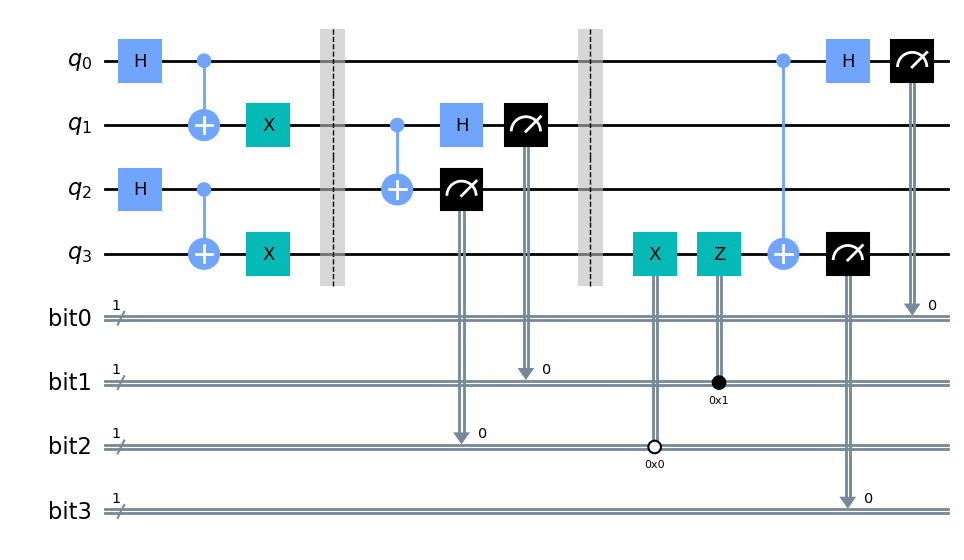

In [10]:
qc_swapping, qubits_swapping = swapping("10")
qc_swapping.draw(output="mpl")

In [11]:
# Con la finalidad de evitar que los qúbits el 100% de las veces estén en un estado clásico, agregamos ruido a las compuertas
import numpy as np
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator

# Importamos el módulo de ruidos de Qiskit Aer
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# Se crea un modelo de ruido vacío
noise_model = NoiseModel()

# Se añade error despolarizante a todas las puertas de un solo qubit u1, u2, u3
error = depolarizing_error(0.001, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Se imprime el modelo de ruido
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


In [12]:
# Se simula el circuito de Entanglement Swapping
sim_swapping = AerSimulator(noise_model=noise_model)
output = execute(qc_swapping, sim_swapping).result()
counts = output.get_counts(qc_swapping)

Text(0.5, 0, 'Estados Clásicos')

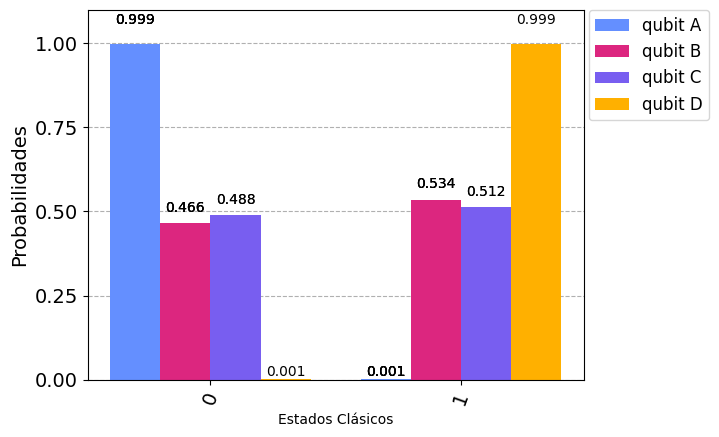

In [13]:
qubit_counts = [marginal_counts(counts, [bit]) for bit in range(4)]
grafica = plt.subplot()
legendas = ["qubit A","qubit B","qubit C","qubit D"]
plot_distribution(qubit_counts, ax=grafica, legend=legendas)
grafica.set_ylabel('Probabilidades')
grafica.set_xlabel('Estados Clásicos')

# Entanglement Swapping con estados Mezcla tipo Werner